# Анализ продаж компьютерных игр
**Цель:** Выявить параметры, определяющие успешность игр, для дальнейшего управления продуктами (определение перспективных / стагнирующих сфер, распределение рекламных бюджетов, текущая / перспективная популярность).

**Выборка:** Исторические данные о выпущенных играх с продажами по регионам. Данные за 2016 год могут быть не полными.

### Описание данных
    
- *Name* — название игры
- *Platform* — платформа
- *Year_of_Release* — год выпуска
- *Genre* — жанр игры
- *NA_sales —* продажи в Северной Америке (миллионы долларов)
- *EU_sales* — продажи в Европе (миллионы долларов)
- *JP_sales* — продажи в Японии (миллионы долларов)
- *Other_sales —* продажи в других странах (миллионы долларов)
- *Critic_Score* — оценка критиков (от 0 до 100)
- *User_Score* — оценка пользователей (от 0 до 10)
- *Rating* — рейтинг от организации *ESRB* (англ. *Entertainment Software Rating Board).* Эта ассоциация определяет рейтинг компьютерных игр и присваивает им подходящую возрастную категорию.

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.ticker as ticker
import numpy as np
from scipy import stats as st
import os

In [2]:
## Отключим предупреждения Anaconda
import warnings
warnings.simplefilter('ignore')

## Будем отображать графики прямо в jupyter'e
%matplotlib inline
import seaborn as sns
import matplotlib.pyplot as plt

## Графики в svg выглядят более четкими
%config InlineBackend.figure_format = 'svg' 

## Увеличим дефолтный размер графиков
from pylab import rcParams
rcParams['figure.figsize'] = (8, 4)

In [3]:
df = pd.read_csv('games.csv')

In [4]:
df.columns = df.columns.str.lower()

In [5]:
df.head()

,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating
0,Wii Sports,Wii,2006.0,Sports,41.36,28.96,3.77,8.45,76.0,8,E
1,Super Mario Bros.,NES,1985.0,Platform,29.08,3.58,6.81,0.77,NaN,NaN,NaN
2,Mario Kart Wii,Wii,2008.0,Racing,15.68,12.76,3.79,3.29,82.0,8.3,E
3,Wii Sports Resort,Wii,2009.0,Sports,15.61,10.93,3.28,2.95,80.0,8,E
4,Pokemon Red/Pokemon Blue,GB,1996.0,Role-Playing,11.27,8.89,10.22,1.00,NaN,NaN,NaN


In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16715 entries, 0 to 16714
Data columns (total 11 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   name             16713 non-null  object 
 1   platform         16715 non-null  object 
 2   year_of_release  16446 non-null  float64
 3   genre            16713 non-null  object 
 4   na_sales         16715 non-null  float64
 5   eu_sales         16715 non-null  float64
 6   jp_sales         16715 non-null  float64
 7   other_sales      16715 non-null  float64
 8   critic_score     8137 non-null   float64
 9   user_score       10014 non-null  object 
 10  rating           9949 non-null   object 
dtypes: float64(6), object(5)
memory usage: 1.4+ MB


In [7]:
df.isna().sum()

name                  2
platform              0
year_of_release     269
genre                 2
na_sales              0
eu_sales              0
jp_sales              0
other_sales           0
critic_score       8578
user_score         6701
rating             6766
dtype: int64

In [8]:
# Приведем год создание игры к типу int, чтобы можно было проводить операции с датами 
# (предварительно избавимся от пропущенных значений в столбцах также в имени и жанре путем удаления, ибо количество строк 
# с пропусками в них ничтожно мало в сравнении с объемом изучаемых данных)
df = df.dropna(subset=['name', 'year_of_release', 'genre'])
df.year_of_release = df.year_of_release.astype(int)

Со столбцами оценок и рейтинга посмотрим на распределения данных и заменим пропущенные значения на
медиану или среднее, в зависимости от распределения 

<AxesSubplot:>

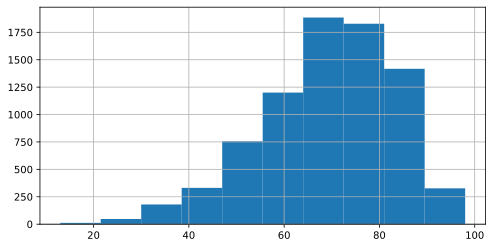

In [9]:
df.critic_score.hist()

In [10]:
df.rating = df.rating.fillna('Unknown')
df.loc[df['rating'] == 'AO', 'rating'] = "M"
df.loc[df['rating'] == 'RP', 'rating'] = "Unknown"
df.loc[df['rating'] == 'K-A', 'rating'] = "E"
df.loc[df['rating'] == 'EC', 'rating'] = "E"

In [11]:
df.rating.value_counts()

Unknown    6677
E          3932
T          2905
M          1537
E10+       1393
Name: rating, dtype: int64

In [12]:
df.critic_score = df.critic_score.fillna(-100) 

In [13]:
df.critic_score = df.critic_score.astype(float)

In [14]:
df.user_score = df.user_score.fillna(-100)
df.loc[df['user_score'] == 'tbd', 'user_score'] = -100

In [15]:
df.user_score = df.user_score.astype(float)

In [16]:
df['total_sales'] = df.na_sales + df.eu_sales + df.jp_sales
df.head()

,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating,total_sales
0,Wii Sports,Wii,2006,Sports,41.36,28.96,3.77,8.45,76.0,8.0,E,74.09
1,Super Mario Bros.,NES,1985,Platform,29.08,3.58,6.81,0.77,-100.0,-100.0,Unknown,39.47
2,Mario Kart Wii,Wii,2008,Racing,15.68,12.76,3.79,3.29,82.0,8.3,E,32.23
3,Wii Sports Resort,Wii,2009,Sports,15.61,10.93,3.28,2.95,80.0,8.0,E,29.82
4,Pokemon Red/Pokemon Blue,GB,1996,Role-Playing,11.27,8.89,10.22,1.00,-100.0,-100.0,Unknown,30.38


### Итог очистки данных
- Привели все данные к необходимому типу
- Нашли пропуски и лишние значения и заменили их
- Посичтали сумму продажи по всем регионам

 # Разведочный анализ данных

<AxesSubplot:>

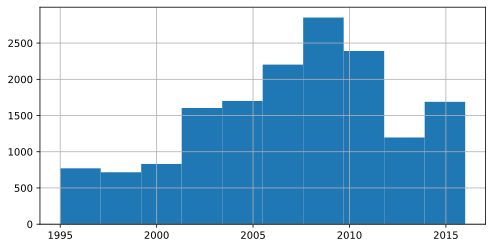

In [17]:
df.query('year_of_release > 1994').year_of_release.hist()

Будем исследовать данные игр, выпущенных после 1995 года, так как в то время индустрия только зарождалась и критерии оценки были иные. Это допустимо ввиду того, что на тот момент игры значительно отличались по наполению и их количество ничтожно мало.
Примечательно, что больше всего игр было выпущено с 2005 по 2012 годы.

<AxesSubplot:xlabel='platform', ylabel='total_sales'>

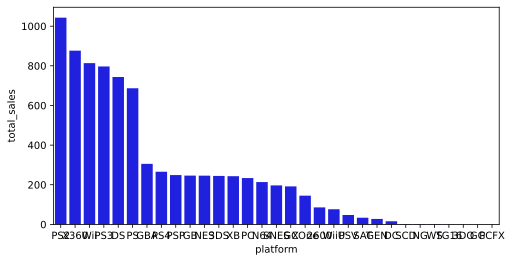

In [18]:
plat = df.pivot_table(index = 'platform', values = 'total_sales', aggfunc='sum')\
         .reset_index()\
         .sort_values(by = 'total_sales', ascending = False)
sns.barplot(data = plat, x = 'platform', y = 'total_sales', color='blue')

На графике очевидны лидеры по продажам - 6 платформ
- PS2
- X360
- Wii
- PS3
- DS
- PS
Изучим распределение продаж для данныхз платформ по годам

<AxesSubplot:xlabel='year_of_release'>

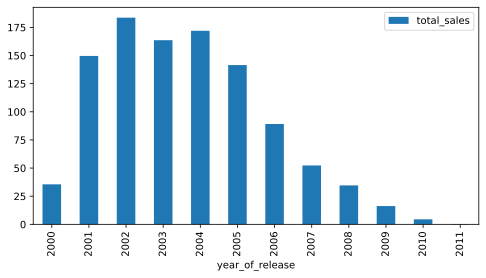

In [19]:
df.query('platform == "PS2"').pivot_table(index = 'year_of_release', values = 'total_sales', aggfunc = 'sum' ).plot(kind = "bar")

<AxesSubplot:xlabel='year_of_release'>

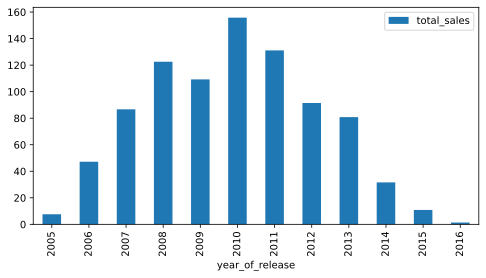

In [20]:
df.query('platform == "X360"').pivot_table(index = 'year_of_release', values = 'total_sales', aggfunc = 'sum' ).plot(kind = "bar")

<AxesSubplot:xlabel='year_of_release'>

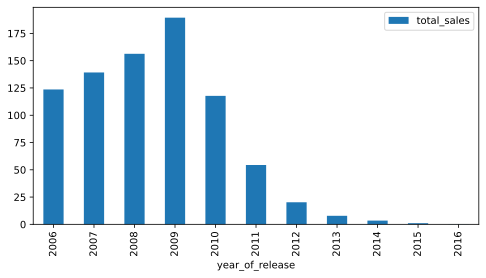

In [21]:
df.query('platform == "Wii"').pivot_table(index = 'year_of_release', values = 'total_sales', aggfunc = 'sum' ).plot(kind = "bar")

<AxesSubplot:xlabel='year_of_release'>

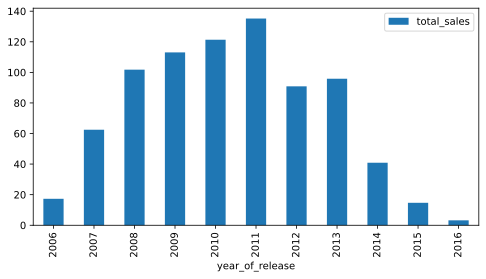

In [22]:
df.query('platform == "PS3"').pivot_table(index = 'year_of_release', values = 'total_sales', aggfunc = 'sum' ).plot(kind = "bar")

<AxesSubplot:xlabel='year_of_release'>

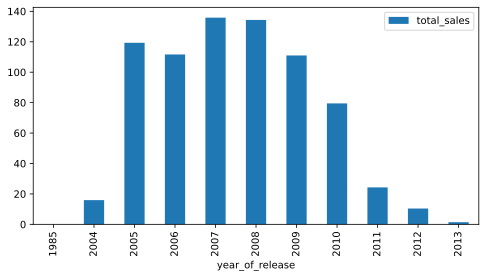

In [23]:
df.query('platform == "DS"').pivot_table(index = 'year_of_release', values = 'total_sales', aggfunc = 'sum' ).plot(kind = "bar")

<AxesSubplot:xlabel='year_of_release'>

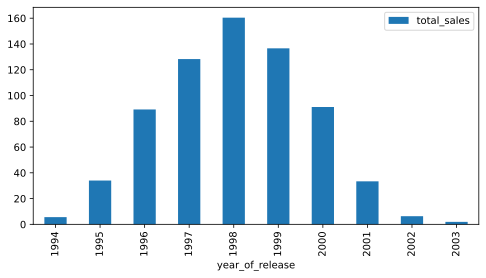

In [24]:
df.query('platform == "PS"').pivot_table(index = 'year_of_release', values = 'total_sales', aggfunc = 'sum' ).plot(kind = "bar")

Исходя из анализа графиков видно, что в зависимости от появления новых поколений PlayStation, соответственно формировался и спрос на игры для этих платформ.
Платформа DS имеет имела увспех с 2005 по 2010, расцвет платформы пришелся на 2009 год.
Такжже примечательно, что с ростом поколения PS, спрос на игры растет пропорционально.

Учитывая тот факт, что в рассматриваемом сегменте самых продаваемых игр, наиболее ранние данные приходятся на 1994, что неактуально для  прогноза на 2017г, ввиду этого имеет смысл рассмартивать данные с 2013 по 2016 г. 

In [25]:
df = df.query('year_of_release >= 2013').copy()
df.shape

(2233, 12)

<AxesSubplot:xlabel='platform'>

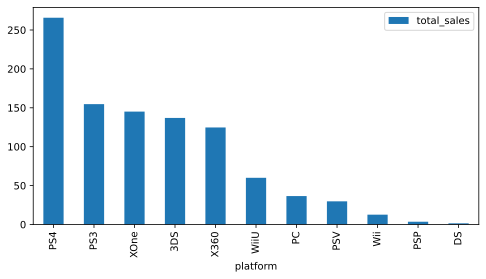

In [26]:
df.pivot_table(index = 'platform', values = 'total_sales', aggfunc='sum').sort_values(by = 'total_sales', ascending = False).plot(kind = 'bar')

Судя по получившимуся графику, продажи по платформе PS значительно растут для новых версий продукта, чего нельзя сказать про Xbox, у которых увеличиние продаж незначительное. Также заметный прирост покупателей у платформы DS (3 версия продукта пользовалась высоким спросом).

Чтобы выяснить, какие платформы можно считать потенциально прибыльными необходимо построить графики
распределения продаж игр для определенных платформ по 4 годам. 

<AxesSubplot:xlabel='year_of_release'>

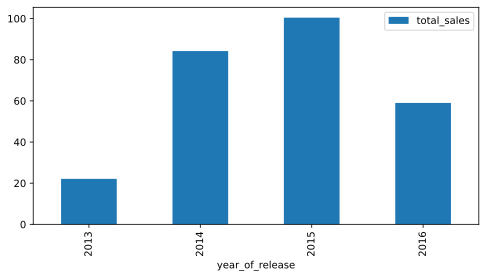

In [27]:
df.query('platform == "PS4"').pivot_table(index = 'year_of_release', values = 'total_sales', aggfunc='sum').plot(kind = 'bar')

<AxesSubplot:xlabel='year_of_release'>

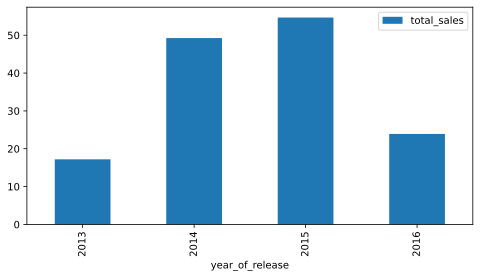

In [28]:
df.query('platform == "XOne"').pivot_table(index = 'year_of_release', values = 'total_sales', aggfunc='sum').plot(kind = 'bar')

Учитывая то, что данные за 2016 год неполные, допустимо сделать вывод о том, что на платформах 

<AxesSubplot:xlabel='year_of_release'>

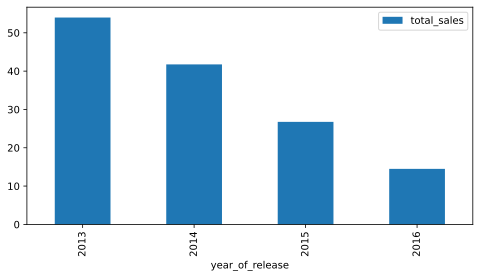

In [29]:
df.query('platform == "3DS"').pivot_table(index = 'year_of_release', values = 'total_sales', aggfunc='sum').plot(kind = 'bar')

На платформе 3DS наблюдается выраженный спад.

<AxesSubplot:xlabel='year_of_release'>

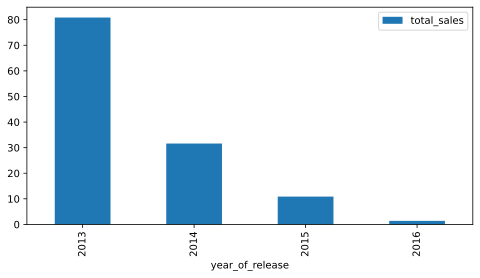

In [30]:
df.query('platform == "X360"').pivot_table(index = 'year_of_release', values = 'total_sales', aggfunc='sum').plot(kind = 'bar')

<AxesSubplot:xlabel='year_of_release'>

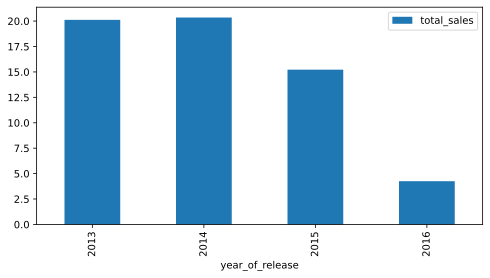

In [31]:
df.query('platform == "WiiU"').pivot_table(index = 'year_of_release', values = 'total_sales', aggfunc='sum').plot(kind = 'bar')

Таким образом из перспективных платформ можно выделить XOne и PS4, однако для анализа нужно значительно большее количество платформ, поэтому исключим из итогового датасета те платформы, которые однозначно утратили актульанось - "PS3", "X360", "Wii", "PSP".

In [32]:
df_fresh = df.query('platform not in["PS3", "X360", "Wii", "PSP"]')


[Text(0.5, 1.0, 'Общие продажи по всем платформам'), (0.0, 3.0)]

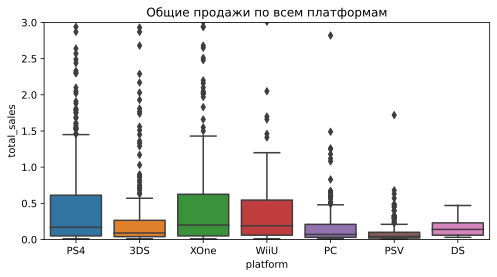

In [33]:
sns.boxplot(data = df_fresh, x = 'platform', y = 'total_sales').set(title = 'Общие продажи по всем платформам', ylim = (0,3))

График очередной раз подтверждает предположение о том, что наиболее перспективные платформы - "PS4", "XOne", а также среди лидеров появилась платформа "WiiU".
Для большей достоверности посмотрим на сводную таблицу.

In [34]:
df_fresh.pivot_table(index = 'platform', values = ['total_sales'],aggfunc = ['var', 'median', 'mean'])\
        .sort_values(by = ('median','total_sales'), ascending = False)

,var,median,mean
,total_sales,total_sales,total_sales
platform,,,
XOne,0.888140,0.20,0.587247
WiiU,0.931977,0.19,0.521217
PS4,1.836625,0.17,0.678036
DS,0.025021,0.14,0.177500
3DS,1.709174,0.09,0.452046
PC,0.104343,0.07,0.192963
PSV,0.017456,0.04,0.083045


Что и следовало ожидать, лидеры по медиане "XOne", "WiiU", "PS4"

##  Как влияют на продажи внутри одной из популярной платформы отзывы пользователей и критиков. Постройте диаграмму рассеяния и посчитайте корреляцию между отзывами и продажами.

In [35]:
# Интересно рассмотреть несколько платформ, чтобы избежать переписывания одного и тогоже по несколько раз
# и не делать тетрадь еще толще, создадим функцию
def corr_on_platform(plat):
    game_plat = df_fresh.query(f'platform == "{plat}"')         
    game_plat.query('user_score != -100').plot\
            .scatter (title = 'Связь продаж с оценками пользователей',
                 figsize = (5,3), 
                 x = 'user_score', 
                 y = 'total_sales')
    game_plat.query('critic_score != -100').plot\
            .scatter (title = 'Связь продаж с оценками критиков',
                      figsize = (5,3), 
                      x = 'critic_score', 
                      y = 'total_sales')

    print(game_plat.query('user_score != -100 and critic_score != -100')[['user_score','critic_score', 'total_sales']]\
            .corr())

              user_score  critic_score  total_sales
user_score      1.000000      0.557654    -0.032923
critic_score    0.557654      1.000000     0.405223
total_sales    -0.032923      0.405223     1.000000


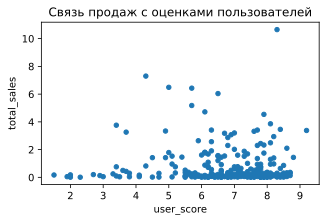

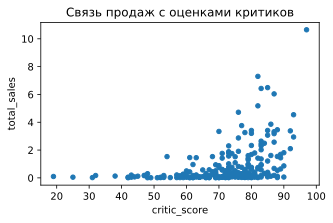

In [36]:
corr_on_platform('PS4')

Оценка критиков имеет слабое влияние на продажи всего 0.4 аналогично оценкам пользователей

              user_score  critic_score  total_sales
user_score      1.000000      0.769536     0.272542
critic_score    0.769536      1.000000     0.337887
total_sales     0.272542      0.337887     1.000000


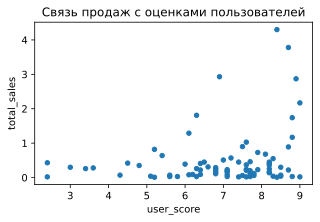

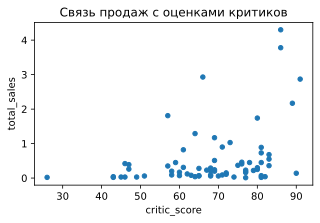

In [37]:
corr_on_platform('3DS')

В данном случае корреляция также мала и составляет не более 0.3

              user_score  critic_score  total_sales
user_score      1.000000      0.721313     0.407859
critic_score    0.721313      1.000000     0.377701
total_sales     0.407859      0.377701     1.000000


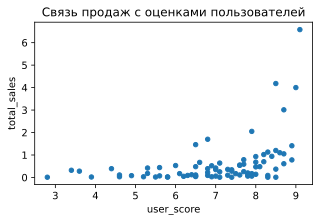

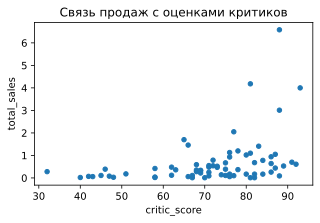

In [38]:
corr_on_platform('WiiU')

              user_score  critic_score  total_sales
user_score      1.000000      0.472462    -0.093737
critic_score    0.472462      1.000000     0.410657
total_sales    -0.093737      0.410657     1.000000


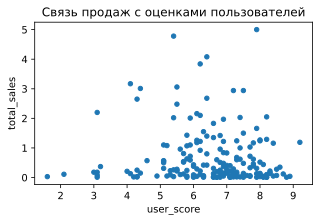

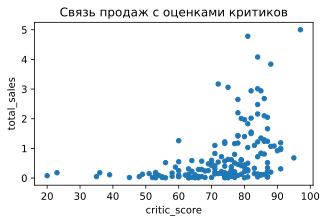

In [39]:
corr_on_platform('XOne')

              user_score  critic_score  total_sales
user_score      1.000000      0.611521     0.265157
critic_score    0.611521      1.000000     0.259536
total_sales     0.265157      0.259536     1.000000


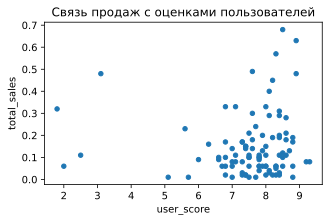

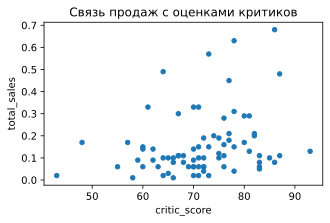

In [40]:
corr_on_platform('PSV')

              user_score  critic_score  total_sales
user_score      1.000000      0.429562    -0.107108
critic_score    0.429562      1.000000     0.195058
total_sales    -0.107108      0.195058     1.000000


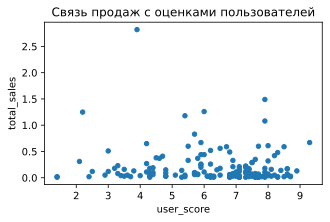

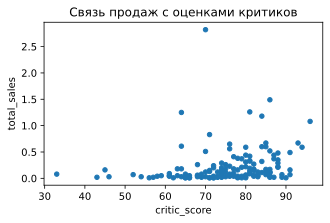

In [41]:
corr_on_platform('PC')

Аналогичная тенденция наблюдается для всех основных платформ, ввиду этого имеет место предположение о том, что стоимость не имеют прямой зависимости от оценок

### Вывод:
Послпе анализа всех перспективных игровых платформ выяснилось, что продажи слабо коррелируют с оценками критиков, оценки пользователей также слабо коррелируют с ценой продажи, либо не коррелируют вовсе.

- Посмотрите на общее распределение игр по жанрам. Что можно сказать о самых прибыльных жанрах? Выделяются ли жанры с высокими и низкими продажами?

<AxesSubplot:xlabel='total_sales', ylabel='genre'>

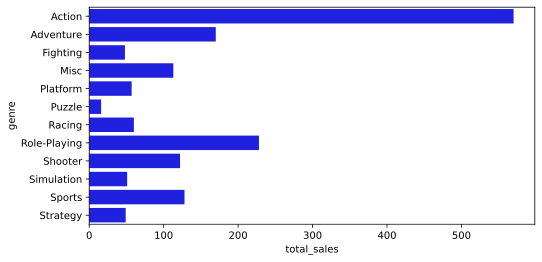

In [42]:
genre_sales_count = df_fresh.pivot_table(index = 'genre', values = 'total_sales', aggfunc='count').reset_index()
sns.barplot(data =genre_sales_count, x = 'total_sales', y = 'genre', color = 'blue', orient='h')

Очевидна тройка лидирующих жанров по количеству - ролевые, шутеры и приключения соответственно.

In [43]:
genre_sales_sum = df_fresh.pivot_table(index = 'genre', values = 'total_sales', aggfunc='sum').reset_index()

<AxesSubplot:xlabel='total_sales', ylabel='genre'>

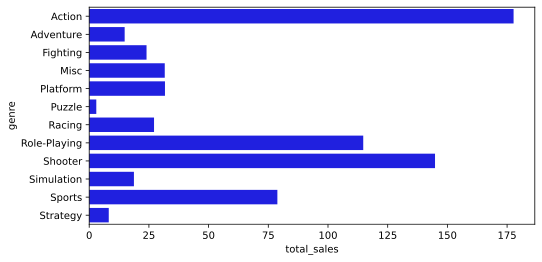

In [44]:
sns.barplot(data =genre_sales_sum, x = 'total_sales', y = 'genre', color = 'blue', orient='h')

Среди самых продаваемых жанров Экшн, шутеры, ролевые и спортивыне соответстыенно.
Наиболее низкие продажи у пазлов и стратегий.

*Интересное наблюдение: по количеству выпущенных игр, приключенческий жанр превосходит спортивный, а по продажам картина противоположная.*

### Далее составим портрет геймера каждого региона.

  Определите для пользователя каждого региона (*NA, EU, JP*):
    - Самые популярные платформы (топ-5). Опишите различия в долях продаж.
    - Самые популярные жанры (топ-5). Поясните разницу.
    - Влияет ли рейтинг ESRB на продажи в отдельном регионе?
    
    **Шаг 5. Проверьте гипотезы**
    
    - Средние пользовательские рейтинги платформ *Xbox One* и *PC* одинаковые;
    - Средние пользовательские рейтинги жанров *Action* (англ. «действие») и *Sports* (англ. «виды спорта») разные.
    
    Задайте самостоятельно пороговое значение *alpha*.
    
    Поясните:
    
    - Как вы сформулировали нулевую и альтернативную гипотезы;
    - Какой критерий применили для проверки гипотез и почему.
    
    **Шаг 6. Напишите общий вывод**

Text(0, 0.5, 'Объъем продаж, млн')

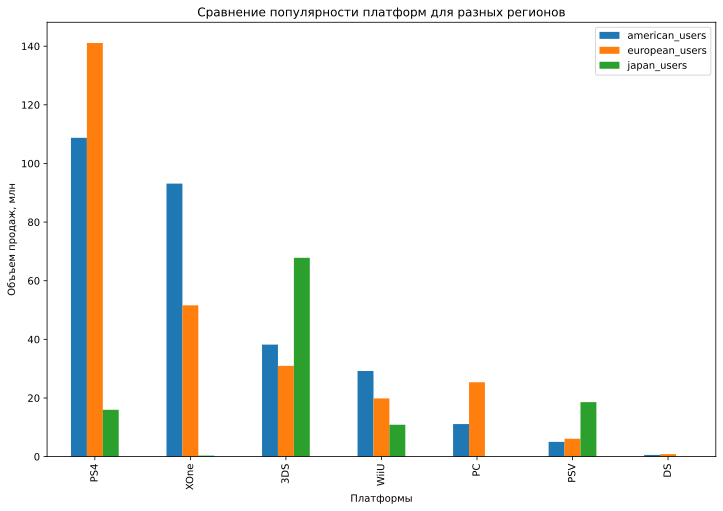

In [52]:
na = df_fresh.pivot_table(index = 'platform', values = 'na_sales', aggfunc='sum')
eu = df_fresh.pivot_table(index = 'platform', values = 'eu_sales', aggfunc='sum')
jp = df_fresh.pivot_table(index = 'platform', values = 'jp_sales', aggfunc='sum')
all_users = pd.concat([na,eu,jp], axis = 1).reset_index()
all_users.columns = ['platform', 'american_users', 'european_users', 'japan_users']
all_users = all_users.sort_values(by = 'american_users', ascending = False)
all_users.plot.bar(x = 'platform', figsize = (12,8))
plt.title('Сравнение популярности платформ для разных регионов')
plt.xlabel('Платформы')
plt.ylabel('Объъем продаж, млн')

Лидирующую позицию в **Америке** и **Европе** занимает платформа **"PS4"**, для **Японии** это платформа **"3DS"**.
На втором и третьем месте для **Америки** и **Европы** - **"XOne"** и **3DS**.
Интересный факт, что в выборке нет данных по продажам в **Японии** игр под платформу **"XOne" и "PC"** и **"DS"**.
Для **Японии** на втором и третьем месте **"PS4"** и **"PSV"** соответственно.


Text(0, 0.5, 'Объъем продаж, млн')

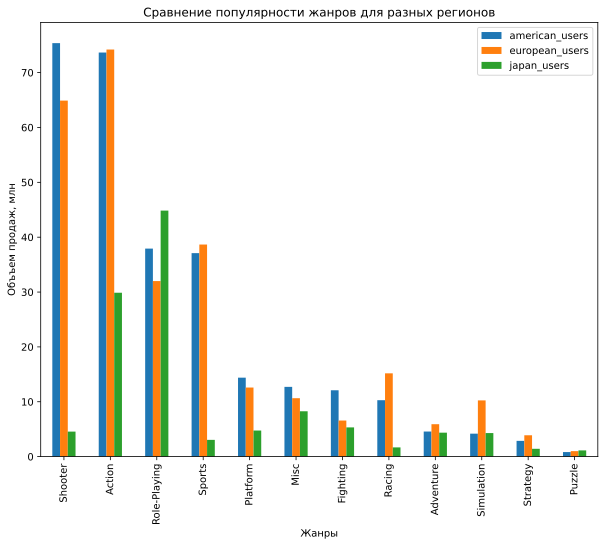

In [57]:
na_g = df_fresh.pivot_table(index = 'genre', values = 'na_sales', aggfunc='sum')
eu_g = df_fresh.pivot_table(index = 'genre', values = 'eu_sales', aggfunc='sum')
jp_g = df_fresh.pivot_table(index = 'genre', values = 'jp_sales', aggfunc='sum')
all_users = pd.concat([na_g,eu_g,jp_g], axis = 1).reset_index()
all_users.columns = ['genre', 'american_users', 'european_users', 'japan_users']
all_users = all_users.sort_values(by = 'american_users', ascending = False)
all_users.plot.bar(x = 'genre', figsize = (10,8))
plt.title('Сравнение популярности жанров для разных регионов')
plt.xlabel('Жанры')
plt.ylabel('Объъем продаж, млн')

## График наглядно иллюстрирует следующее
 - Наиболее распространенные жанры для Америки: шутеры (около 75 млн суммарных продаж), а также экшн (более 70 млн продаж), третье место разделили ролевыой жанр и спорт (около 48 млн)
 - Наиболее распространенные жанры для Европы: экшн (около 75 млн суммарных продаж), шутеры (54 млн) и спорт (около 36 млн)
 - Наиболее распространенные жанры для Японии: ролевые (45 млн), экшн (29 млн), жанр "Misc" (около 10 млн)

Text(0, 0.5, 'Объъем продаж, млн')

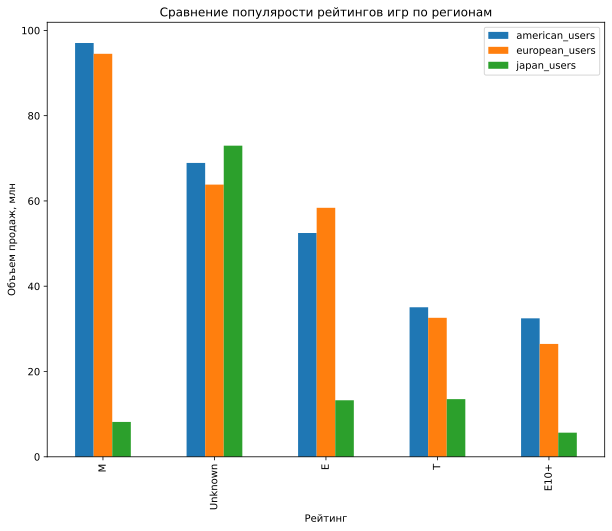

In [56]:
na_r = df_fresh.pivot_table(index = 'rating', values = 'na_sales', aggfunc='sum')
eu_r = df_fresh.pivot_table(index = 'rating', values = 'eu_sales', aggfunc='sum')
jp_r = df_fresh.pivot_table(index = 'rating', values = 'jp_sales', aggfunc='sum')
all_users = pd.concat([na_r,eu_r,jp_r], axis = 1).reset_index()
all_users.columns = ['rating', 'american_users', 'european_users', 'japan_users']
all_users = all_users.sort_values(by = 'american_users', ascending = False)
all_users.plot.bar(x = 'rating', figsize = (10,8))
plt.title('Сравнение популярости рейтингов игр по регионам')
plt.xlabel('Рейтинг')
plt.ylabel('Объъем продаж, млн')

## График может иметь следующую итерпритацию
- Наибольшее количество купленных игр в Америке имели рейтинг M (17+), Unknown, Т и Е
- Наибольшее количество купленных игр в Европе имели рейтинг M (17+), Unknown, E и T
- В Японии большинство игр не имеют ретинга (в рамках имеющегостя датасета) 

## Вывод
В итоге получилось создать портрет пользователя для трех регионов. Портреты для Америки и Европы схожи (что может быть объяснено рядом факторов, например культурной составляющей и особенностями рынка) лидирующей платформой являеется "PS4", наиболле распространенные жанры Шутеры и экшн, с ретинг чаще всего M.
Япония значительно отличается от остальных: наиболее распространенная платформа "3DS", интересующие жанры ролевые и экшн, чще всего рейтинг Unknown.


# ПРОВЕРКА ГИПОТЕЗ

- Средние пользовательские рейтинги платформ *Xbox One* и *PC* одинаковые;
- Средние пользовательские рейтинги жанров *Action* (англ. «действие») и *Sports* (англ. «виды спорта») разные.

**Гипотеза:**
- средние пользовательские рейтинги платформ Xbox One и PC одинаковые -- H0
-  средние пользовательские рейтинги платформ Xbox One и PC различаются -- H1


In [62]:
score_for_XOne = df_fresh.query('platform == "XOne" and user_score != -100').user_score
score_for_PC = df_fresh.query('platform == "PC" and user_score != -100').user_score
alpha = 0.05
results = st.ttest_ind(score_for_XOne, score_for_PC)

print(results.pvalue)
if results.pvalue < alpha:
    print('Есть основания отвергнуть нулевую гипотезу')
else: print('Нет достаточных оснований отвергнуть нулевую гипотезу')

0.14012658403611647
Нет достаточных оснований отвергнуть нулевую гипотезу


Таким образом имеет место предположение об отсутствии статистически значимых различий между средними пользовательских рейтингов платформ Xbox One и PC.

**Гипотеза:**
- средние пользовательские рейтинги жанров "Action" и "Sports" одинаковые -- H0
-  средние пользовательскиерейтинги жанров "Action" и "Sports" различаются -- H1


In [64]:
score_for_action = df_fresh.query('genre == "Action" and user_score != -100').user_score
score_for_sport = df_fresh.query('genre == "Sports" and user_score != -100').user_score
alpha = 0.05
results = st.ttest_ind(score_for_action, score_for_sport)

print(results.pvalue)
if results.pvalue < alpha:
    print('Есть основания отвергнуть нулевую гипотезу')
else: print('Нет достаточных оснований отвергнуть нулевую гипотезу')

9.446919621063131e-15
Есть основания отвергнуть нулевую гипотезу


# Итоговый вывод

В ходе выполнения тестового проекта было проведено изучение сета данных о игровых предпочтениях трех регионов. В проецессе выполнения была проведена очистка данных, приведене их к верному формату.
- Исследуя год выпуска игр было вявлено, что в зависимости от появления новых поколений PlayStation, соответственно формировался и спрос на игры для этих платформ.Платформа DS имеет имела увспех с 2005 по 2010, расцвет платформы пришелся на 2009 год.Такжже примечательно, что с ростом поколения PS, спрос на игры растет пропорционально.
- В процессе изучения перспективных платформ было воявлено, что из наиболее перспективных платформ можно выделить XOne и PS4, однако для анализа нужно значительно большее количество платформ, поэтому исключим из итогового датасета те платформы, которые однозначно утратили актульанось - "PS3", "X360", "Wii", "PSP".
- Также исследование зависимотси стоимости от оценок показало, что продажи слабо коррелируют с оценками критиков, оценки пользователей также слабо коррелируют с ценой продажи, либо не коррелируют вовсе.
- Тройка лидирующих жанров по количеству проданных экземпляров - ролевые, шутеры и приключения соответственно.
- Среди самых продаваемых жанров Экшн, шутеры, ролевые и спортивыне соответстыенно. Наиболее низкие продажи у пазлов и стратегий. 
- В итоге получилось создать портрет пользователя для трех регионов. Портреты для Америки и Европы схожи (что может быть объяснено рядом факторов, например культурной составляющей и особенностями рынка) лидирующей платформой являеется "PS4", наиболле распространенные жанры Шутеры и экшн, с ретинг чаще всего M. Япония значительно отличается от остальных: наиболее распространенная платформа "3DS", интересующие жанры ролевые и экшн, чще всего рейтинг Unknown.